In [1]:
# import packages
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [2]:
# i/o
work_dir = '.'

img_path = work_dir + '/data/HE_allen_brain_atlas/60_100142143_289.jpg'
df_path = work_dir + '/data/Puck_200115_08_bead_locations.csv'
leiden_path = work_dir + '/store/leiden.csv'
STalign_df_path = work_dir + '/store/ST_align_result.csv'
BoReMi_df_path = work_dir + '/store/Updated_Spatial_Data.csv'
BoReMi_img_path = work_dir + '/store/Updated_H&E_image.jpg'

In [3]:
# import data
img = plt.imread(img_path) # H&E image
df = pd.read_csv(df_path, header=None, skiprows=1, index_col=0) # Slide-seq bead coordinates
leiden = pd.read_csv(leiden_path, header=None, skiprows=1, index_col=0) # Slide-seq bead clusters


In [4]:
df = df.merge(leiden, how='left', left_index=True, right_index=True)
df.columns = ['xcoord', 'ycoord', 'cluster']
df = df.dropna()

In [5]:
STalign_df = pd.read_csv(STalign_df_path)
STalign_df = STalign_df.dropna()

In [6]:
BoReMi_df = pd.read_csv(BoReMi_df_path) # Slide-seq bead coordinates after BoReMi alignment
BoReMi_img = plt.imread(BoReMi_img_path) # BoReMi-adjusted H&E image

In [7]:
BoReMi_df.index = BoReMi_df['cell id']
BoReMi_df = BoReMi_df.merge(df['cluster'], how='right', left_index=True, right_index=True)
BoReMi_df['flip y'] = BoReMi_img.shape[0] - BoReMi_df['final y']


In [8]:
# create colour palette
colors = [
    '#e6194b',  # red
    '#3cb44b',  # green
    '#ffe119',  # yellow
    '#4363d8',  # blue
    '#f58231',  # orange
    '#911eb4',  # purple
    '#46f0f0',  # cyan
    '#f032e6',  # magenta
    '#bcf60c',  # lime
    '#fabebe',  # pink
    '#008080'   # teal
]

custom_cmap = ListedColormap(colors)

In [9]:
# map cluster number to colour in palette
cluster_list = df['cluster'].unique().tolist()
cluster_list = [str(i) for i in cluster_list]
cluster_list = [i.replace('.0','') for i in cluster_list]

cluster_dict = {}

for i in range(len(cluster_list)):
    cluster_dict[cluster_list[i]] = colors[i]

numeric_clusters = [c for c in cluster_list if c != 'nan']
numeric_clusters_sorted = sorted(numeric_clusters, key=int)
if 'nan' in cluster_list:
    numeric_clusters_sorted.append('nan')

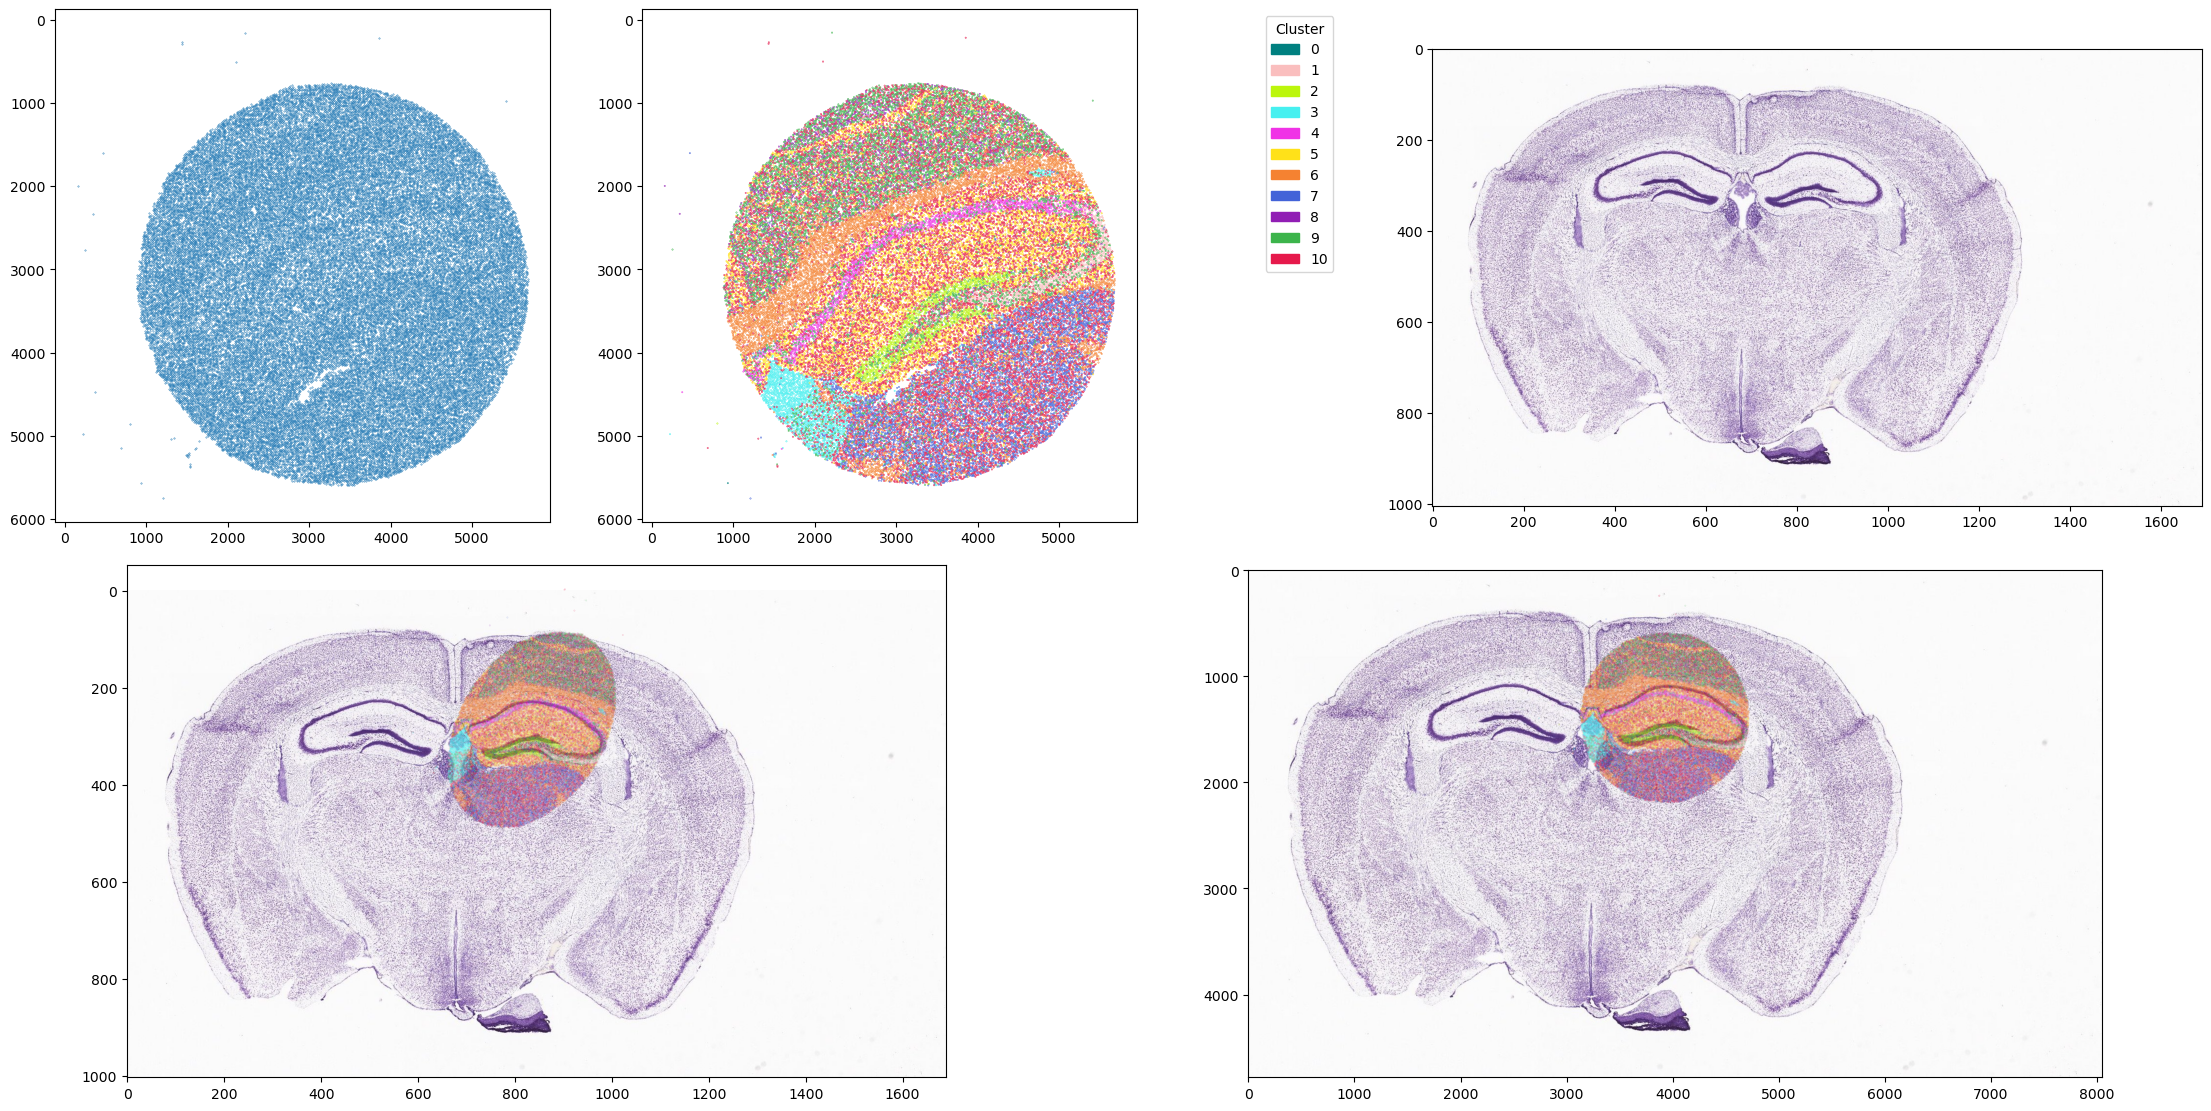

In [10]:
fig = plt.figure(layout='constrained', figsize=(22, 11))

# divide into 2 rows
subfigs = fig.subfigures(2, 1, wspace=0.07, height_ratios=[1, 1])
row0 = subfigs[0].subfigures(1, 4, wspace=0.07, width_ratios=[1, 1, 0.3, 1.5])
row1 = subfigs[1].subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])


# plot Slide-seq bead coordinates 
axs00 = row0[0].subplots(1, 1)
axs00.scatter(df['xcoord'], df['ycoord'], s=0.1, rasterized=True)
axs00.invert_yaxis()


# plot Slide-seq bead coordinates, coloured by cluster
axs01 = row0[1].subplots(1, 1)
axs01.scatter(df['xcoord'], df['ycoord'], s=0.1, c=df['cluster'], rasterized=True, cmap=custom_cmap)
axs01.invert_yaxis()


# plot cluster labels
axs02 = row0[2].subplots(1, 1)
patch_list = []
    
for i in range(len(numeric_clusters_sorted)):
    patch_list.append(mpatches.Patch(color=cluster_dict[numeric_clusters_sorted[i]], label=numeric_clusters_sorted[i]))
axs02.legend(handles=patch_list, title='Cluster')
axs02.axis('off')


# plot H&E image
axs03 = row0[3].subplots(1, 1)
axs03.imshow(img)


# plot STalign-aligned H&E image and Slide-seq bead coordinates
axs10 = row1[0].subplots(1, 1)
axs10.imshow(img)
axs10.scatter(STalign_df['aligned_x'], STalign_df['aligned_y'],s=0.1, alpha=0.2, c=STalign_df['cluster'], rasterized=True, cmap=custom_cmap)
axs10.set_aspect('equal')


# plot BoReMi-aligned H&E image and Slide-seq bead coordinates
axs11 = row1[1].subplots(1, 1)
axs11.imshow(BoReMi_img)
axs11.scatter(BoReMi_df['final x'], BoReMi_df['flip y'],s=0.1, alpha=0.2, c=BoReMi_df['cluster'], rasterized=True, cmap=custom_cmap)

In [11]:
fig.savefig(work_dir + '/store/plot_test_fig.svg', dpi=300)